# Basic Fashion MNIST

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import sklearn.metrics as metrics
import torch
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 64

## transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

## download and load training dataset
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2, drop_last = True)

## download and load testing dataset
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)#, target_transform=target_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2, drop_last=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [3]:
from collections import Counter
counter = Counter(trainset.targets.tolist())
counter

Counter({9: 6000,
         0: 6000,
         3: 6000,
         2: 6000,
         7: 6000,
         5: 6000,
         1: 6000,
         6: 6000,
         4: 6000,
         8: 6000})

The dataset is perfectly balanced and the creation of validation set as usual would create a bias (imbalanced number of items in each category).

In [4]:
trainset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [5]:
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

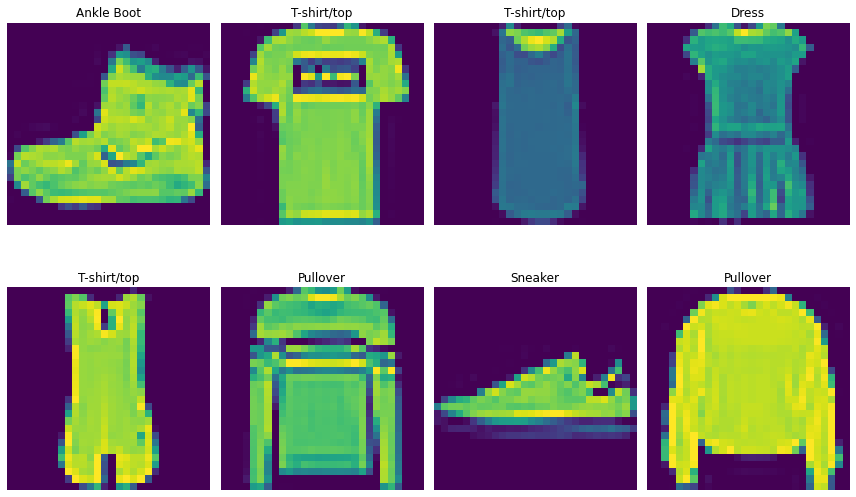

In [6]:
f, ax = plt.subplots(2,4, figsize=(12,8))

for i, img in enumerate(trainset.data[:8]):
    ax[i//4, i%4].imshow(img)
    ax[i//4, i%4].axis('off')
    ax[i//4, i%4].set_title(labels[int(trainset.targets[i])])
plt.tight_layout()
plt.show()  

In [7]:
counter_test = Counter(testset.targets.tolist())
counter_test

Counter({9: 1000,
         2: 1000,
         1: 1000,
         6: 1000,
         4: 1000,
         5: 1000,
         7: 1000,
         3: 1000,
         8: 1000,
         0: 1000})

In [8]:
testset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

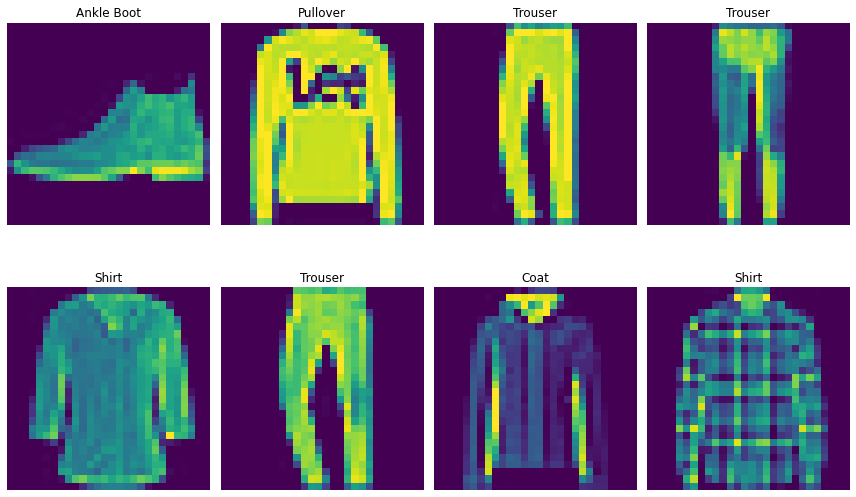

In [9]:
f, ax = plt.subplots(2,4, figsize=(12,8))

for i, img in enumerate(testset.data[:8]):
    ax[i//4, i%4].imshow(img)
    ax[i//4, i%4].axis('off')
    ax[i//4, i%4].set_title(labels[int(testset.targets[i])])
plt.tight_layout()
plt.show()  

In [10]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1,stride=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2,stride=2)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=1)
        self.fc = nn.Linear(12 * 12 * 128, 128)
        self.out = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.batchnorm1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.batchnorm2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.batchnorm3(x)
        x = self.pool3(x)

        x = x.flatten(start_dim = 1)
        

        x = self.fc(x)
        x = F.relu(x)

        # logits => 64x10
        logits = self.out(x)
        return logits

In [42]:
lr = 0.0005
epochs = 30

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNNClassifier()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.)


In [6]:
def train_validation(model, criterion, optimizer, device, trainloader, testloader, epochs):
    training_losses = []
    test_losses = []
    best_model_state_dict = None
    best_model_accuracy = 0.
    best_model_test_loss = torch.inf
    best_epoch = 0
    
    for epoch in tqdm(range(epochs)):    
        training_loss = 0.0
        test_loss = 0.0
        train_acc = 0.
        test_acc = 0.
        
        model.train()
        for images, labels in tqdm(trainloader):
        
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            training_loss += loss.detach().item() / len(trainloader)
            train_acc += (torch.argmax(logits, 1).flatten() == labels).type(torch.float).mean().item() / len(trainloader)
        training_losses.append(training_loss)
        print('Epoch: %d | training Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, training_loss, train_acc))
        
        
        model.eval()
        with torch.no_grad():
            for images, labels in tqdm(testloader):
                images = images.to(device)
                labels = labels.to(device)

                logits = model(images)
                loss = criterion(logits, labels)
                
                test_loss += loss.item() / len(testloader)
                test_acc += (torch.argmax(logits, 1).flatten() == labels).type(torch.float).mean().item() / len(testloader)
            test_losses.append(test_loss)
        if test_loss < best_model_test_loss:
            best_model_test_loss = test_loss
            best_model_accuracy = test_acc
            best_model_state_dict = model.state_dict()
            best_epoch = epoch
            print('Model improved! Epoch: %d | Test loss is %.4f, test accuracy is %.4f' \
                  %(epoch, test_loss, test_acc))
    
        if epoch - best_epoch >= 2:
            break
    return training_losses, test_losses, best_model_accuracy, best_model_state_dict

In [45]:
train_losses, test_losses, best_model_accuracy, best_model_state_dict = train_validation(model, criterion,
                                                                                         optimizer, device,
                                                                                         trainloader, testloader,
                                                                                         epochs)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 0 | training Loss: 0.3141 | Train Accuracy: 0.89


  0%|          | 0/156 [00:00<?, ?it/s]

Model improved! Epoch: 0 | Test loss is 0.2881, test accuracy is 0.8950


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 1 | training Loss: 0.2060 | Train Accuracy: 0.92


  0%|          | 0/156 [00:00<?, ?it/s]

Model improved! Epoch: 1 | Test loss is 0.2684, test accuracy is 0.9067


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 2 | training Loss: 0.1587 | Train Accuracy: 0.94


  0%|          | 0/156 [00:00<?, ?it/s]

Model improved! Epoch: 2 | Test loss is 0.2676, test accuracy is 0.9105


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 3 | training Loss: 0.1259 | Train Accuracy: 0.95


  0%|          | 0/156 [00:00<?, ?it/s]

Model improved! Epoch: 3 | Test loss is 0.2634, test accuracy is 0.9196


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 4 | training Loss: 0.1011 | Train Accuracy: 0.96


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 5 | training Loss: 0.0817 | Train Accuracy: 0.97


  0%|          | 0/156 [00:00<?, ?it/s]

In [47]:
best_model_accuracy

0.9195713141025647

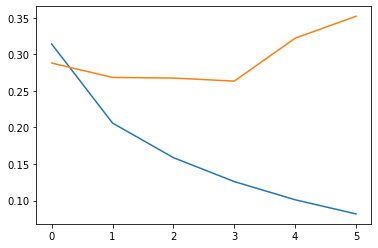

In [50]:
plt.figure(figsize=(6,4))
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()

I forgot to save the validation and test losses before my Collab session died, so they are not labeled. Test losses are in orage, training losses are in blue.
It can be seen that the model starts overfitting and the early stopping is triggered. The early stopping is only two epochs of no improvement because the dataset is large and the model must improve over itterations.

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [59]:
torch.save(best_model_state_dict, '/content/drive/My Drive/model1.pkl')

In [12]:
model = CNNClassifier()
model.load_state_dict(torch.load('/content/drive/My Drive/model1.pkl'))

<All keys matched successfully>

In [15]:
y_pred_list = []
y_true_list = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()
with torch.no_grad():
    for images, labels in tqdm(testloader):
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)        
        #test_acc += (torch.argmax(logits, 1).flatten() == labels).type(torch.float).mean().item() / len(testloader)
        y_pred_list.extend(torch.argmax(logits, 1).flatten().numpy())
        y_true_list.extend(labels.numpy())

  0%|          | 0/156 [00:00<?, ?it/s]

In [22]:
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

In [28]:
list(labels.keys())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

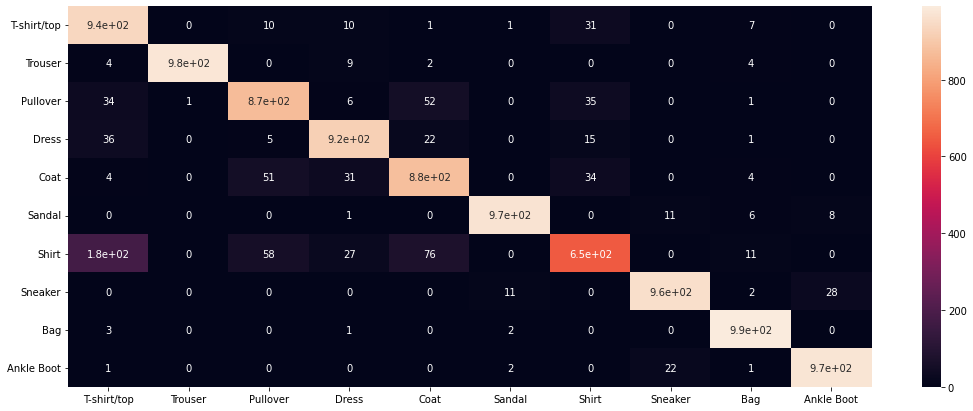

In [31]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
cm = confusion_matrix(y_true_list, y_pred_list)
df_cm = pd.DataFrame(cm, columns=list(labels.values()), index=list(labels.values()))
plt.figure(figsize = (18,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
# It looks like a large number of the erros come from the model predicting that a shirt is a T-shirt/top but not the other way round.
# the rows are the ground truth, the columns are the predictions

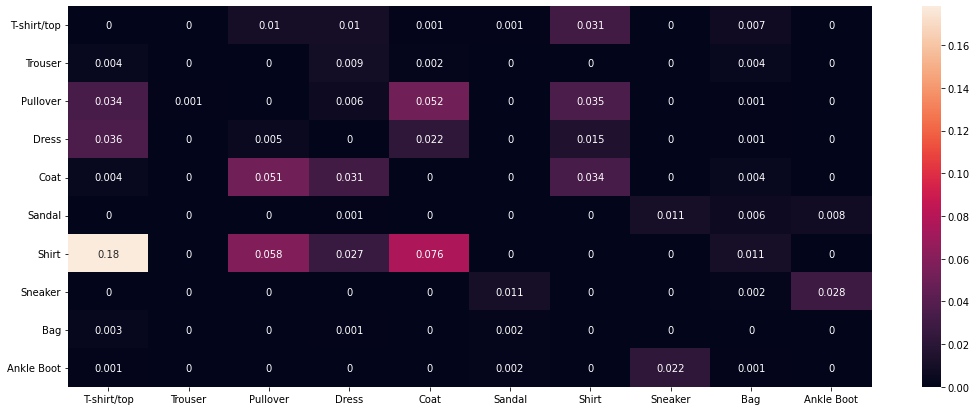

In [34]:
import numpy as np
row_sums = cm.sum(axis=1, keepdims=True)
norm_conf_mx = cm / row_sums
np.fill_diagonal(norm_conf_mx, 0)
df_norm_conf_mx = pd.DataFrame(norm_conf_mx, columns=list(labels.values()), index=list(labels.values()))
plt.figure(figsize=(18,7))
sn.heatmap(df_norm_conf_mx, annot=True)

That is the error analysis which more clearly illustrates the errors the model is making.

Next: precision = TP/ TP + FP

recall = TP/ TP + FN

f1_score = 2 x precision x recall / precision + recall

In [37]:
# Precision, Recall, and F1
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(y_true_list, y_pred_list, average='macro')

0.9152413091962226

In [39]:
recall_score(y_true_list, y_pred_list, average='macro')

0.9139070711686716

In [41]:
f1_score(y_true_list, y_pred_list, average='macro')

0.9124736115555742

In this context we want both the recall and precision to be as high as possible; and the high f1 score favours similar recall and precision scores. There are cases of multiclass classification where we might want one or the other to be as high as possible, for example videos suitable for kids (high precision), or detection of problems (high recall, don't want to have false negatives).

In the case of multiclass classification the scores for each class are computed and averaged (not weighted average).